In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import multiprocessing as mp

c:\users\ligua\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ligua\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ligua\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ligua\appd

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

NUM_FEATURES = 21
NUM_CLASSES = 3

weight_decay_parameter = 0.001
learning_rate = 0.01
epochs = 5000
num_neurons = 10
seed = 10
np.random.seed(seed)

In [3]:
def train(beta):
    batch_size = 32
    hidden_layer_neuron_num = 10
    
    train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
    allX, allY = train_input[1:, :21], train_input[1:,-1].astype(int)
    allX = scale(allX, np.min(allX, axis=0), np.max(allX, axis=0))

    all_x_length = allX.shape[0]
    all_y_length = allY.shape[0]
    
    trainX = allX[:int(all_x_length * 0.7)]
    testX = allX[int(all_x_length * 0.7):]
    
    trainY_temp = allY[:int(all_x_length * 0.7)]
    testY_temp = allY[int(all_x_length * 0.7):]
    trainY = np.zeros((trainY_temp.shape[0], NUM_CLASSES))
    trainY[np.arange(trainY_temp.shape[0]), trainY_temp - 1] = 1 #one hot matrix
    testY = np.zeros((testY_temp.shape[0], NUM_CLASSES))
    testY[np.arange(testY_temp.shape[0]), testY_temp - 1] = 1 #one hot matrix
    
    # construct the ffn
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])
    
    weights_hidden = tf.Variable(
        tf.truncated_normal(
            [NUM_FEATURES, hidden_layer_neuron_num], 
            stddev=1.0/math.sqrt(float(NUM_FEATURES))),
            name='weights')
    biases_hidden = tf.Variable(
        tf.zeros([hidden_layer_neuron_num]),
        name='biases')
    hidden = tf.nn.relu(tf.matmul(x, weights_hidden) + biases_hidden)
    weights_out = tf.Variable(
        tf.truncated_normal(
            [hidden_layer_neuron_num, NUM_CLASSES], 
            stddev=1.0/math.sqrt(float(NUM_FEATURES))),
            name='weights')
    biases_out = tf.Variable(
        tf.zeros([NUM_CLASSES]),
        name='biases')
    logits = tf.matmul(hidden, weights_out ) + biases_out
    regularization = tf.nn.l2_loss(weights_out) + tf.nn.l2_loss(weights_hidden)
    
    y = logits

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
        loss = tf.reduce_mean(cross_entropy + beta*regularization)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_acc = []
        test_acc = []
        
        for i in range(1, (epochs + 1)):
            num_of_batch =  trainX.shape[0] // batch_size + 1
            for j in range(num_of_batch):
                first_index = (j - 1) * batch_size
                last_index = j * batch_size
                if last_index > len(trainX):
                    last_index = len(trainX)
                train_op.run(feed_dict={x: trainX[first_index:last_index], y_: trainY[first_index:last_index]})
            
            train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
            
            if i % 100 == 0:
                print('iter %d: train accuracy %g'%(i, train_acc[i - 1]))
                print('iter %d: test accuracy %g'%(i, test_acc[i - 1]))
            
        return train_acc, test_acc

iter 100: train accuracy 0.863575
iter 100: test accuracy 0.778997
iter 200: train accuracy 0.899866
iter 200: test accuracy 0.799373
iter 300: train accuracy 0.909274
iter 300: test accuracy 0.778997
iter 400: train accuracy 0.909946
iter 400: test accuracy 0.766458
iter 500: train accuracy 0.905242
iter 500: test accuracy 0.766458
iter 600: train accuracy 0.905914
iter 600: test accuracy 0.760188
iter 700: train accuracy 0.90793
iter 700: test accuracy 0.763323
iter 800: train accuracy 0.90793
iter 800: test accuracy 0.761755
iter 900: train accuracy 0.908602
iter 900: test accuracy 0.753918
iter 1000: train accuracy 0.909274
iter 1000: test accuracy 0.749216
iter 1100: train accuracy 0.91129
iter 1100: test accuracy 0.747649
iter 1200: train accuracy 0.911962
iter 1200: test accuracy 0.746082
iter 1300: train accuracy 0.913306
iter 1300: test accuracy 0.741379
iter 1400: train accuracy 0.913979
iter 1400: test accuracy 0.739812
iter 1500: train accuracy 0.915995
iter 1500: test accu

iter 100: train accuracy 0.857527
iter 100: test accuracy 0.76489
iter 200: train accuracy 0.898521
iter 200: test accuracy 0.775862
iter 300: train accuracy 0.905914
iter 300: test accuracy 0.769592
iter 400: train accuracy 0.907258
iter 400: test accuracy 0.753918
iter 500: train accuracy 0.907258
iter 500: test accuracy 0.746082
iter 600: train accuracy 0.907258
iter 600: test accuracy 0.741379
iter 700: train accuracy 0.909274
iter 700: test accuracy 0.736677
iter 800: train accuracy 0.907258
iter 800: test accuracy 0.733542
iter 900: train accuracy 0.906586
iter 900: test accuracy 0.731975
iter 1000: train accuracy 0.908602
iter 1000: test accuracy 0.733542
iter 1100: train accuracy 0.909274
iter 1100: test accuracy 0.741379
iter 1200: train accuracy 0.909274
iter 1200: test accuracy 0.744514
iter 1300: train accuracy 0.909274
iter 1300: test accuracy 0.746082
iter 1400: train accuracy 0.912634
iter 1400: test accuracy 0.742947
iter 1500: train accuracy 0.912634
iter 1500: test ac

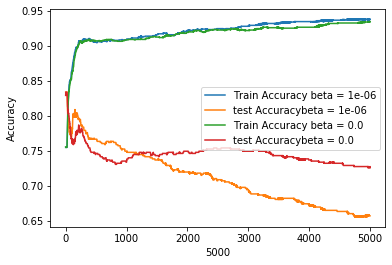

In [4]:
def main():
    betas = [0.000001, 0.0]
    
    accs = []
    for beta in betas:
        acc = train(beta)
        print(acc)
        accs.append(acc)
        
    plt.figure()
    for i in range(len(betas)):
        plt.plot(range(epochs), accs[i][0], label='Train Accuracy beta = {}'.format(betas[i]))
        plt.plot(range(epochs), accs[i][1], label='test Accuracybeta = {}'.format(betas[i]))
        
    plt.xlabel(str(epochs))
    plt.ylabel('Accuracy')
    plt.legend()
    plt

if __name__ == '__main__':
    main()